# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Consumer Price Index Data: https://data.nasdaq.com/data/RATEINF/CPI_EUR-consumer-price-index-euro-area

### 1. Importing your libraries and data

Before you start this analysis, you'll need a new library you haven't installed before—Quandl. Install Quandl using conda:

`conda install quandl`

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [5]:
# Configure API key 

quandl.ApiConfig.api_key = 'ZS5moY_MnxPxWpcyhJmk'

In [1]:
# Importing the Consumer Price Index Data variable.

data = quandl.get('RATEINF/CPI_EUR')

NameError: name 'quandl' is not defined

In [16]:
data.head(10)

,Value
Date,
1990-01-31,69.46
1990-02-28,69.71
1990-03-31,69.88
1990-04-30,70.14
1990-05-31,70.30
1990-06-30,70.39
1990-07-31,70.39
1990-08-31,70.81
1990-09-30,71.32


In [17]:
data.shape

(399, 1)

In [18]:
data.columns

Index(['Value'], dtype='object')

In [19]:
type(data)

pandas.core.frame.DataFrame

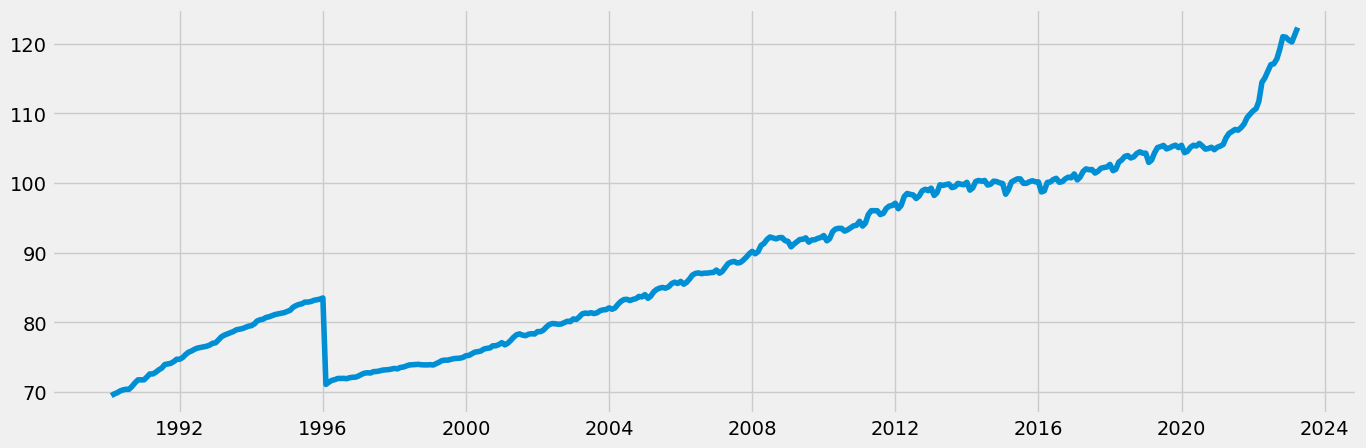

In [20]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

#### The dataset contains observations between January-1990 and March-2023.

### 2. Subsetting, wrangling, and cleaning time-series data

In [21]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [22]:
data_2.head()

,Date,Value
0,1990-01-31,69.46
1,1990-02-28,69.71
2,1990-03-31,69.88
3,1990-04-30,70.14
4,1990-05-31,70.30


In [23]:
data_sub = data_2.loc[(data_2['Date'] >= '2000-01-01') & (data_2['Date'] < '2023-03-31')]

In [24]:
data_sub.shape

(278, 2)

In [25]:
data_sub.head()

,Date,Value
120,2000-01-31,75.25
121,2000-02-29,75.49
122,2000-03-31,75.72
123,2000-04-30,75.79
124,2000-05-31,75.88


In [26]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2000-01-31,75.25
2000-02-29,75.49
2000-03-31,75.72
2000-04-30,75.79
2000-05-31,75.88


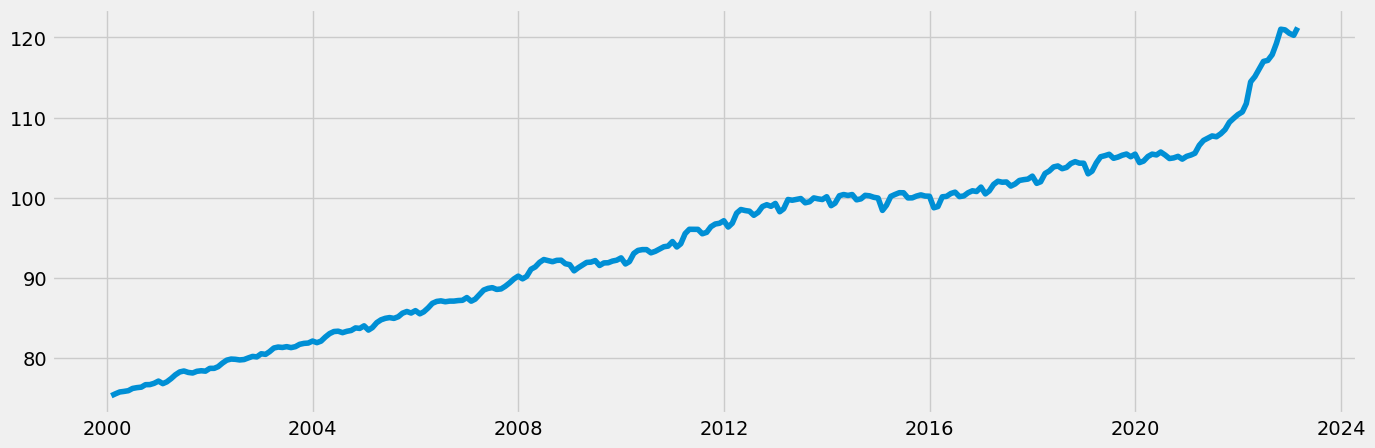

In [27]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

Filtered the dataset to 2000-January onwards.

In [28]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [35]:
# Check for duplicates

dups = data_sub.duplicated(keep=False)

In [34]:
dups.sum()

18

In [37]:
print(dups)
# When duplicated() returns False for a row, it means that the row is not a duplicate. In other words, there is no other identical row in the DataFrame that matches the current row in terms of all column values.
# No dups!

datetime
2000-01-31    False
2000-02-29    False
2000-03-31    False
2000-04-30    False
2000-05-31    False
              ...  
2022-10-31    False
2022-11-30    False
2022-12-31    False
2023-01-31    False
2023-02-28    False
Length: 278, dtype: bool


### 3. Time-series analysis: decomposition

In [38]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [39]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

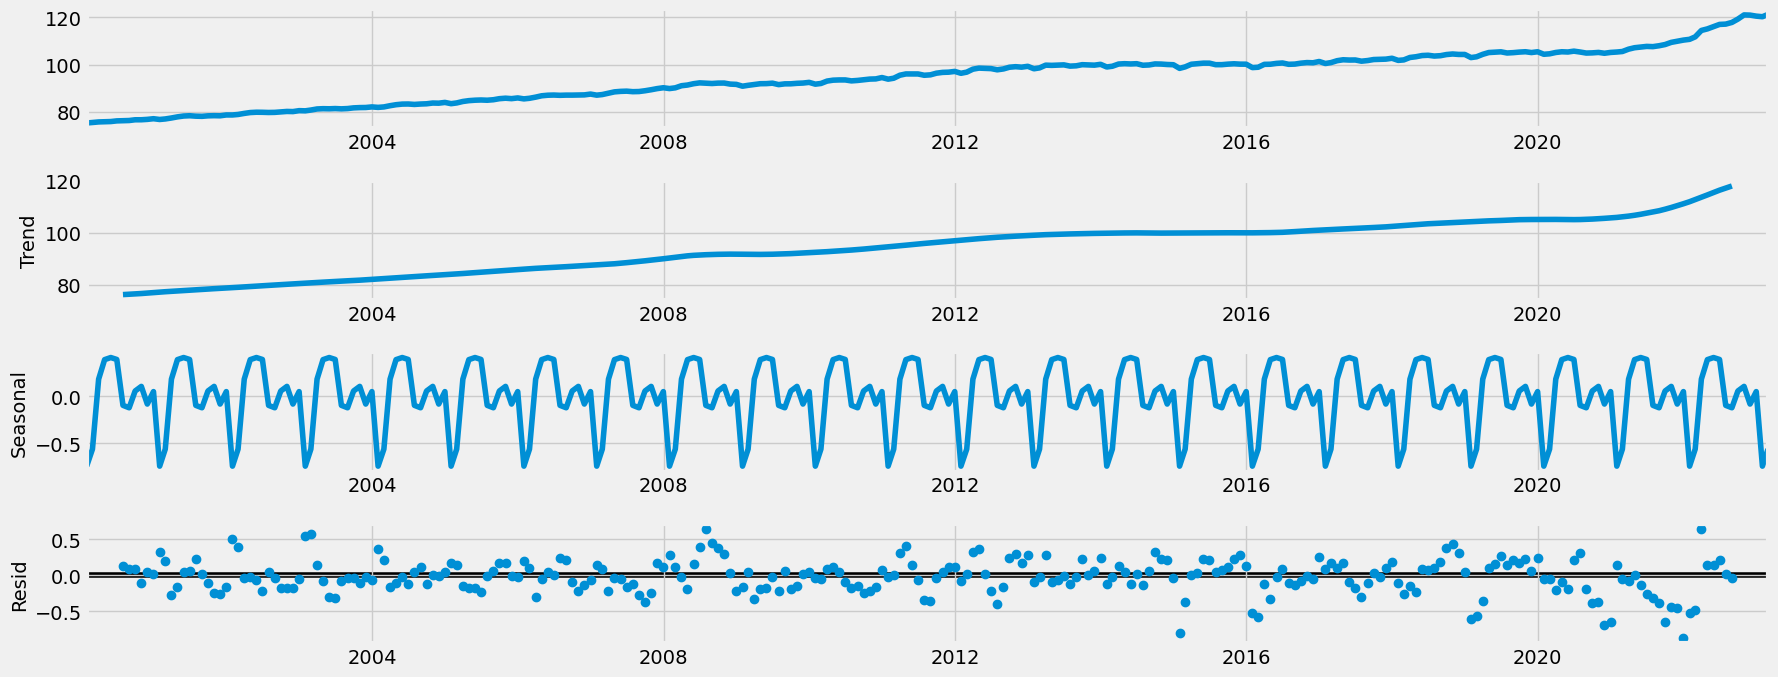

In [40]:
# Plot the separate components

decomposition.plot()
plt.show()

The first chart in the figure above is the data itself.

The second is the underlying trend. As data that doesn’t have much noise, the level and trend appear the same.

The third component is the seasonality. There are seasonal fluctuations represented by a spikey curve that changes at a regular interval. Without seasonality (which is rarely the case), the curve would be flat.

The fourth is the noise—or, as it’s called here, “residual.” Think of it as what’s left of the data after the trend and seasonality have been extracted (hence the term residual). You can see here that there isn’t much unexplained noise, apart from the period of time around the 2009 financial crisis and since 2022, where there are a number of up-and-down deviations.

### 4. Testing for stationarity

In [41]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.010450
p-value                          0.994375
Number of Lags Used             16.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64


Test statistic larger than critical value = can’t reject null hypothesis

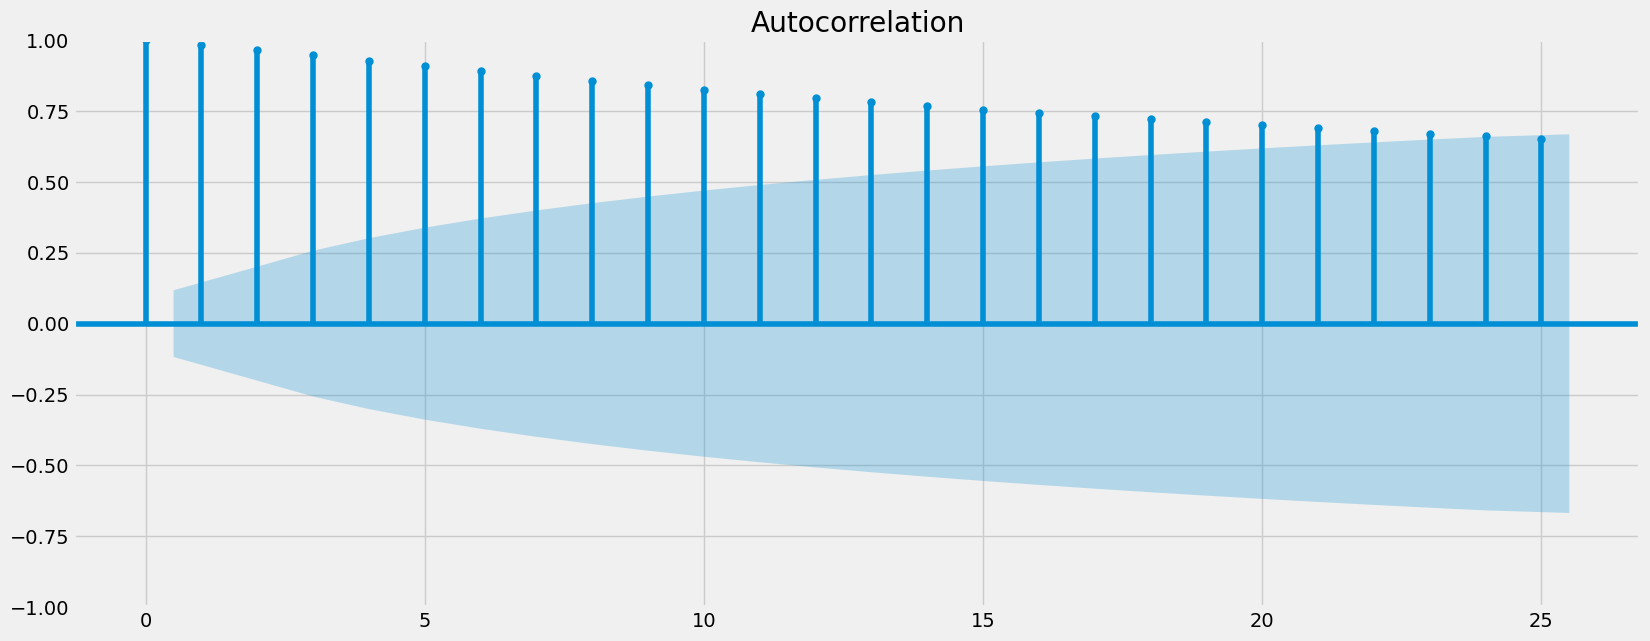

In [42]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. 

When lines go above the blue edge of the confidence interval, this means you have lags that are significantly correlated with each other. 

And when you have many lags beyond this interval, you can deduce that your data is non-stationary. As you can see from the above example, the Federal Reserve time series has quite a few lags correlated with each other. 

This means there’s a lot of autocorrelated data and the set is likely non-stationary, which supports the result of the Dickey-Fuller test conducted earlier.

A stationary time series refers to one whose statistical measures (e.g., mean, variance, etc.) remain constant. 

If the mean of a time series increases or decreases over a certain period of time, that time series isn’t stationary. 

The most important thing to remember about stationarity is that it has nothing to do with the data itself, rather the underlying nature and mechanisms that drive it.

### 5. Stationarizing the Inflation Rates Data

In [43]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [44]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [45]:
data_diff.head()

,Value
datetime,
2000-02-29,0.24
2000-03-31,0.23
2000-04-30,0.07
2000-05-31,0.09
2000-06-30,0.28


In [46]:
data_diff.columns

Index(['Value'], dtype='object')

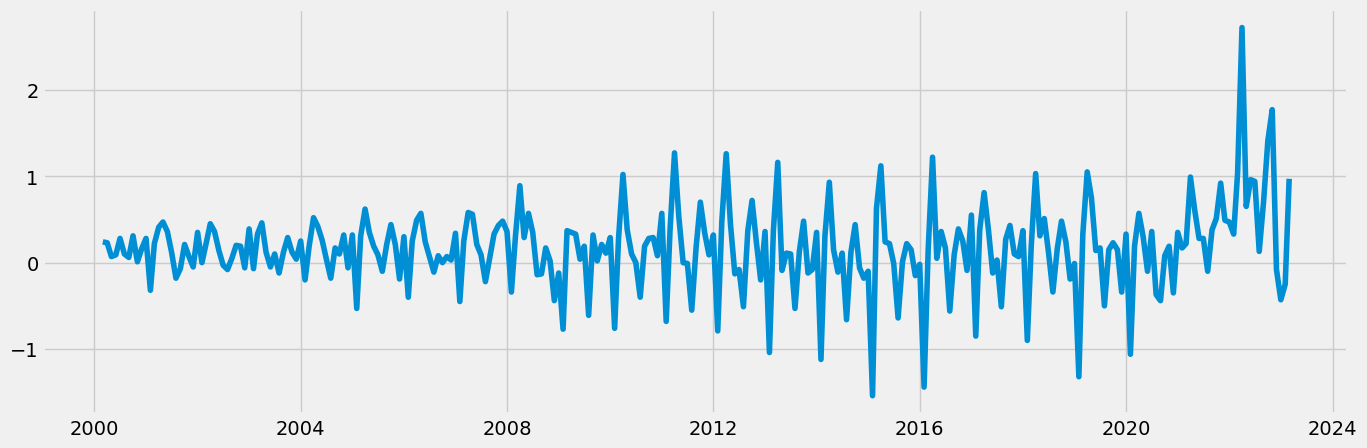

In [47]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [48]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.216855
p-value                          0.200185
Number of Lags Used             15.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64


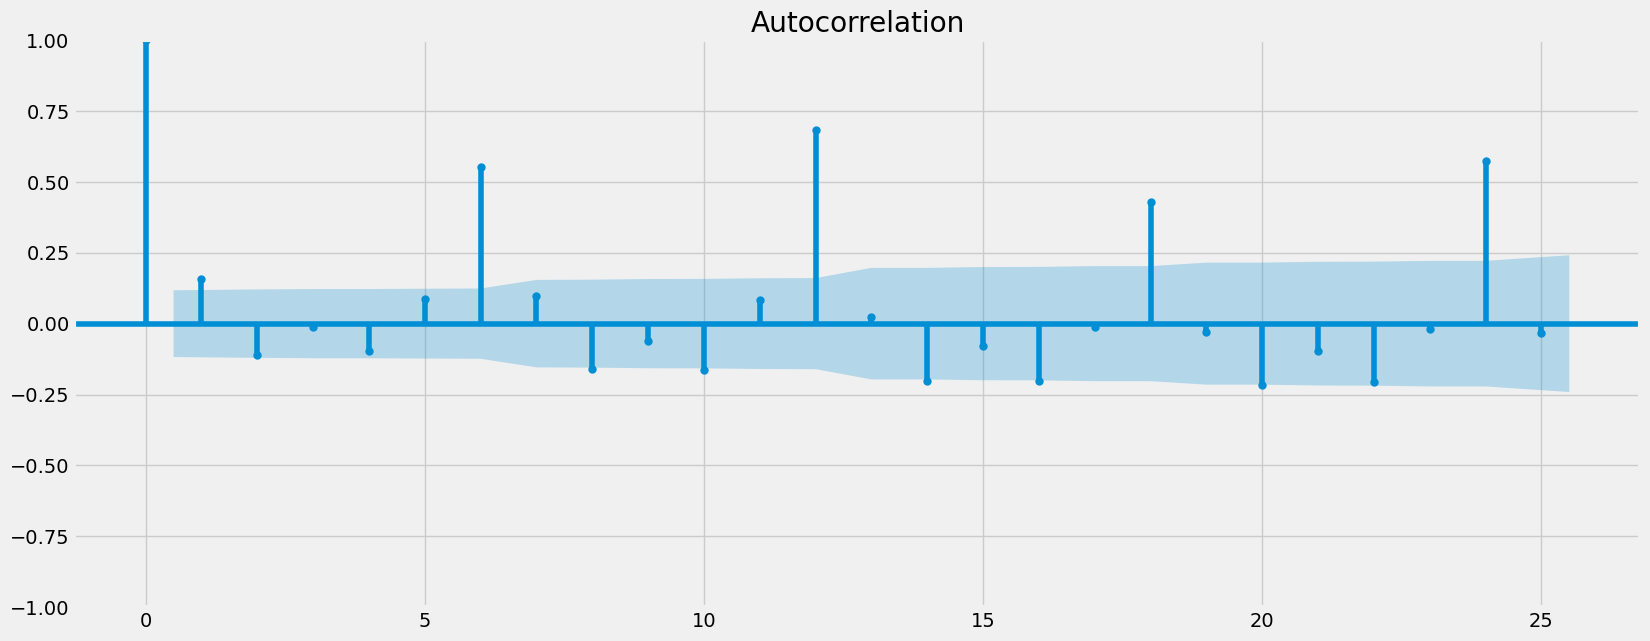

In [49]:
plot_acf(data_diff)
plt.show()

While the autocorrelation plot has improved (there are fewer autocorrelated terms), it’s still not perfect. This means that, despite the Dickey-Fuller test saying that the data is stationary, that stationarity is weak.